# Results Markov

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

working dir /home/tales/dev/master/mdc_analysis


In [2]:
import pandas as pd
import math
import copy
import gc
import warnings
import matplotlib.pyplot as plt

from bokeh.palettes import Category20c

import src.ml.markov as mk
from src.dao.experiments_dao import load_execution_test_data, json_to_dataframe
from src.exceptions import exceptions

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.float_format', lambda x: '%.3f' % x)


## Loading data

In [4]:
def round_up_list(num_list):
    rounded = [math.ceil(i) for i in num_list]
    return rounded

def hits_contain(df):
    df = copy.deepcopy(df)
    df["hits_contain"] = df["partial_hits"].apply(lambda lista : round_up_list(lista))
    df["hits_contain_mean"] = df["partial_hits"].apply(lambda lista : pd.Series(round_up_list(lista)).mean())
    return df

def json_to_dataframe(json_list, simple_cols=True):
    df = pd.DataFrame(json_list)
    
    df["iteration"] = df["iteration"].astype(str)
    df["k"] = df["k"].astype(str)
    
    df["acc"] = df["total_hits"] / df["test_size"]
    
    df["partial_hits_mean"] = df["partial_hits"].apply(lambda lista : pd.Series(lista).mean())
    
    df_markov = df[df["algorithm"] == "markov"]
    df_rest = df[df["algorithm"] != "markov"]
    
    df_markov = hits_contain(df_markov)
    
    df = df_markov.append(df_rest)
    
    df_markov = None
    df_rest = None
    
    gc.collect()
    
    if simple_cols:
        del df["states_not_trained_as_origin"]
        del df["hits"]
        del df["misses"]
        
    return df

In [5]:
results_dir = "clusters"

mk_results = load_execution_test_data(results_dir)
print("{} tests".format(len(mk_results)))

r = json_to_dataframe(mk_results, simple_cols=False)

r_dummy = r[r["is_dummy"] == True]
r = r[r["is_dummy"] == False]

r.sample(4)

3792 tests


,acc,algorithm,cluster_size,cluster_version,hits,hits_contain,hits_contain_mean,input_data_version,is_distributive,is_dummy,...,partial_hits_mean,states_not_trained_as_origin,test_id,test_size,total_hits,total_misses,total_states_not_trained_as_origin,train_size,trained_with,user_id
35,0.202,markov,2,each_one_by_itself,"[['HOME'], ['WORK'], ['restaurant'], ['WORK'],...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...",0.203,0.1.categ_v1_filtered_15min,False,False,...,0.203,[],6fef79cf-807c-4739-8d5c-485e30e4601b,297,60,236,0,297,cluster,6178
2840,0.268,markov,2,each_one_by_itself,"[['transit_station'], ['HOME'], ['transit_stat...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.269,0.1.categ_v1_filtered_30min,False,False,...,0.269,[],9d05a49a-c872-484a-8daf-1af2bf8baad2,157,42,114,0,157,cluster,6194
1003,0.750,markov,2,each_one_by_itself,"[['real_estate_agency'], ['transit_station'], ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]",0.818,0.1.categ_v1_filtered_30min,False,False,...,0.818,[],b1fc1712-0f91-4dd7-8732-ff7823e47926,12,9,2,0,12,cluster,6172
3028,0.163,markov,153,all_vs_one,"[['HOME'], ['HOME'], ['HOME'], ['store'], ['HO...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.164,0.1.categ_v1_filtered_15min,False,False,...,0.164,[],eb10e25e-7391-46dd-b7bd-da214c1abd7a,147,24,122,0,29438,cluster,5957


## Summary

In [6]:
try:
    r["pred_choice_method"] = r["pred_choice_method"].fillna("na")    
except KeyError:
    r["pred_choice_method"] = "na"
    
try:
    r["depth"] = r["depth"].fillna("na")
except KeyError:
    r["depth"] = "na"

In [7]:
r["input_data_version"].value_counts()

0.1.categ_v1                   1290
0.1.categ_v1_filtered_15min    1257
0.1.categ_v1_filtered_30min    1245
Name: input_data_version, dtype: int64

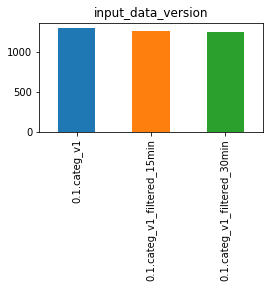

In [8]:
r["input_data_version"].value_counts().plot.bar(title="input_data_version", figsize=(4,2))

In [9]:
r["method"].value_counts()

cluster    3792
Name: method, dtype: int64

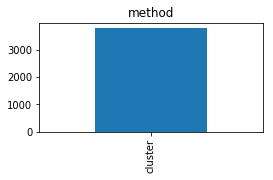

In [10]:
r["method"].value_counts().plot.bar(title="method", figsize=(4,2))

In [11]:
r["algorithm"].value_counts()

markov    3792
Name: algorithm, dtype: int64

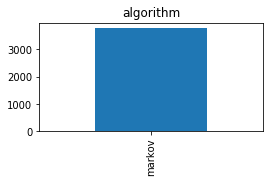

In [12]:
r["algorithm"].value_counts().plot.bar(title="algorithm", figsize=(4,2))

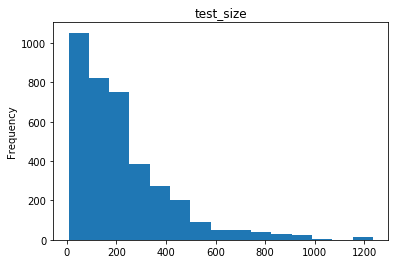

In [13]:
r["test_size"].plot.hist(title="test_size", bins=15)

## Accuracy

In [14]:
r.columns

Index(['acc', 'algorithm', 'cluster_size', 'cluster_version', 'hits',
       'hits_contain', 'hits_contain_mean', 'input_data_version',
       'is_distributive', 'is_dummy', 'iteration', 'k', 'method', 'misses',
       'partial_hits', 'partial_hits_mean', 'states_not_trained_as_origin',
       'test_id', 'test_size', 'total_hits', 'total_misses',
       'total_states_not_trained_as_origin', 'train_size', 'trained_with',
       'user_id', 'pred_choice_method', 'depth'],
      dtype='object')

In [15]:
def summary_results(use_results):
    summarized = []
    
    for algorithm in use_results["algorithm"].drop_duplicates():
        
        for method in use_results["method"].drop_duplicates():
            
            for input_data_version in use_results["input_data_version"].drop_duplicates():
                
                for pred_choice_method in use_results["pred_choice_method"].drop_duplicates():
                    
                    for depth in use_results["depth"].drop_duplicates():
                        
                        for cluster_version in use_results["cluster_version"].drop_duplicates():
                    
                            selection = use_results[(use_results["algorithm"] == algorithm) & 
                                                    (use_results["method"] == method) &
                                                    (use_results["input_data_version"] == input_data_version) &
                                                    (use_results["pred_choice_method"] == pred_choice_method) &
                                                    (use_results["depth"] == depth) &
                                                    (use_results["cluster_version"] == cluster_version)
                                                   ]

                            acc = selection["acc"].median()
                            mad = selection["acc"].mad()

                            summarized.append({"acc": acc, 
                                               "mad": mad,
                                               "algorithm": algorithm, 
                                               "method": method, 
                                               "pred_choice_method": pred_choice_method, 
                                               "input_data": input_data_version,
                                               "depth": depth,
                                               "cluster_version": cluster_version})

    
    return summarized

In [16]:
results_df = pd.DataFrame(summary_results(r))
results_df = results_df[~results_df["acc"].isna()]
results_df.reset_index()

,index,acc,algorithm,cluster_version,depth,input_data,mad,method,pred_choice_method
0,0,0.317,markov,each_one_by_itself,na,0.1.categ_v1_filtered_15min,0.110,cluster,na
1,1,0.332,markov,extreme_trav_each_one_by_itself,na,0.1.categ_v1_filtered_15min,0.146,cluster,na
2,2,0.092,markov,all_vs_one,na,0.1.categ_v1_filtered_15min,0.039,cluster,na
3,3,0.100,markov,all_vs_tireless_its,na,0.1.categ_v1_filtered_15min,0.033,cluster,na
4,4,0.111,markov,all_vs_early_birds,na,0.1.categ_v1_filtered_15min,0.057,cluster,na
5,5,0.156,markov,cluster_early_birds,na,0.1.categ_v1_filtered_15min,0.079,cluster,na
6,6,0.136,markov,cluster_tireless_its,na,0.1.categ_v1_filtered_15min,0.033,cluster,na
7,7,0.059,markov,cluster_night_owls,na,0.1.categ_v1_filtered_15min,0.051,cluster,na
8,8,0.077,markov,all_vs_night_owls,na,0.1.categ_v1_filtered_15min,0.051,cluster,na
9,9,0.275,markov,each_one_by_itself,na,0.1.categ_v1,0.097,cluster,na


In [17]:
results_df["id"] = results_df["cluster_version"] + " : " + results_df["input_data"]

In [18]:
results_01_categ_05min = results_df[results_df["input_data"] == "0.1.categ_v1"]
results_01_categ_05min = results_01_categ_05min.set_index("cluster_version", drop=False)

In [19]:
results_01_categ_15min = results_df[results_df["input_data"] == "0.1.categ_v1_filtered_15min"]
results_01_categ_15min = results_01_categ_15min.set_index("cluster_version", drop=False)

In [20]:
results_01_categ_30min = results_df[results_df["input_data"] == "0.1.categ_v1_filtered_30min"]
results_01_categ_30min = results_01_categ_30min.set_index("cluster_version", drop=False)

In [21]:
comparison = {
              'early_birds': ['all_vs_early_birds', 'cluster_early_birds'],
              'night_owls': ['all_vs_night_owls', 'cluster_night_owls'],
              'tireless_its': ['all_vs_tireless_its', 'cluster_tireless_its'],
              'others': ['all_vs_one', 'each_one_by_itself', 'extreme_trav_each_one_by_itself']
             }

In [22]:
def comparison_index_order(comparison_dict, on_colname, df):
    order = []
    
    for group in comparison_dict.keys():
        for execution_tag in comparison_dict[group]:
            i = df[df[on_colname] == execution_tag].index.item()
            order.append(i)

    return order

In [23]:
order_i_05min = comparison_index_order(comparison, on_colname="cluster_version", df=results_01_categ_05min)
order_i_15min = comparison_index_order(comparison, on_colname="cluster_version", df=results_01_categ_15min)
order_i_30min = comparison_index_order(comparison, on_colname="cluster_version", df=results_01_categ_30min)

In [24]:
results_01_categ_05min

,acc,algorithm,cluster_version,depth,input_data,mad,method,pred_choice_method,id
cluster_version,,,,,,,,,
each_one_by_itself,0.275,markov,each_one_by_itself,na,0.1.categ_v1,0.097,cluster,na,each_one_by_itself : 0.1.categ_v1
extreme_trav_each_one_by_itself,0.299,markov,extreme_trav_each_one_by_itself,na,0.1.categ_v1,0.121,cluster,na,extreme_trav_each_one_by_itself : 0.1.categ_v1
all_vs_one,0.086,markov,all_vs_one,na,0.1.categ_v1,0.027,cluster,na,all_vs_one : 0.1.categ_v1
all_vs_tireless_its,0.100,markov,all_vs_tireless_its,na,0.1.categ_v1,0.017,cluster,na,all_vs_tireless_its : 0.1.categ_v1
all_vs_early_birds,0.100,markov,all_vs_early_birds,na,0.1.categ_v1,0.030,cluster,na,all_vs_early_birds : 0.1.categ_v1
cluster_early_birds,0.123,markov,cluster_early_birds,na,0.1.categ_v1,0.047,cluster,na,cluster_early_birds : 0.1.categ_v1
cluster_tireless_its,0.111,markov,cluster_tireless_its,na,0.1.categ_v1,0.019,cluster,na,cluster_tireless_its : 0.1.categ_v1
cluster_night_owls,0.080,markov,cluster_night_owls,na,0.1.categ_v1,0.046,cluster,na,cluster_night_owls : 0.1.categ_v1
all_vs_night_owls,0.086,markov,all_vs_night_owls,na,0.1.categ_v1,0.059,cluster,na,all_vs_night_owls : 0.1.categ_v1


# Accuracy - Single Partition

In [25]:
my_colors = [Category20c[20][0], Category20c[20][1], Category20c[20][2],
          Category20c[20][4], Category20c[20][5], Category20c[20][6],
          Category20c[20][8], Category20c[20][9], Category20c[20][10], Category20c[20][10]]

## categ_v1

### Stop Region Stay Time: <font color="red">5 minutes</font>

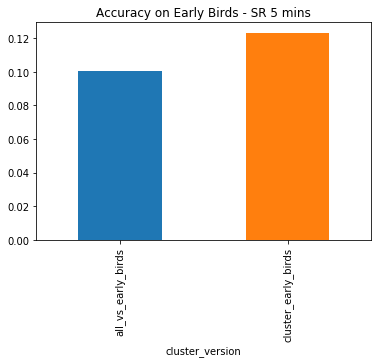

In [26]:
results_01_categ_05min.loc[order_i_05min[0:2]]["acc"].plot.bar(title="Accuracy on Early Birds - SR 5 mins")

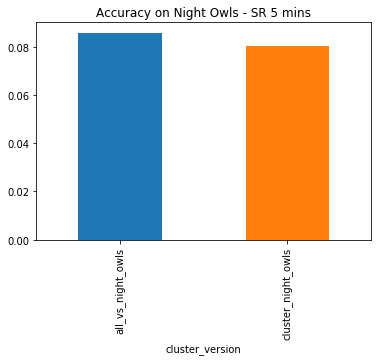

In [27]:
results_01_categ_05min.loc[order_i_05min[2:4]]["acc"].plot.bar(title="Accuracy on Night Owls - SR 5 mins")

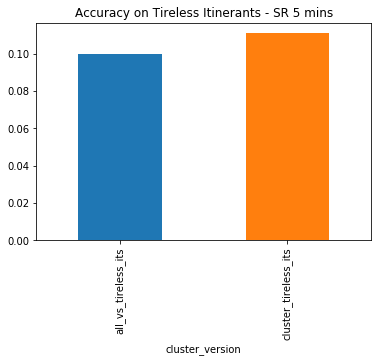

In [28]:
results_01_categ_05min.loc[order_i_05min[4:6]]["acc"].plot.bar(title="Accuracy on Tireless Itinerants - SR 5 mins")

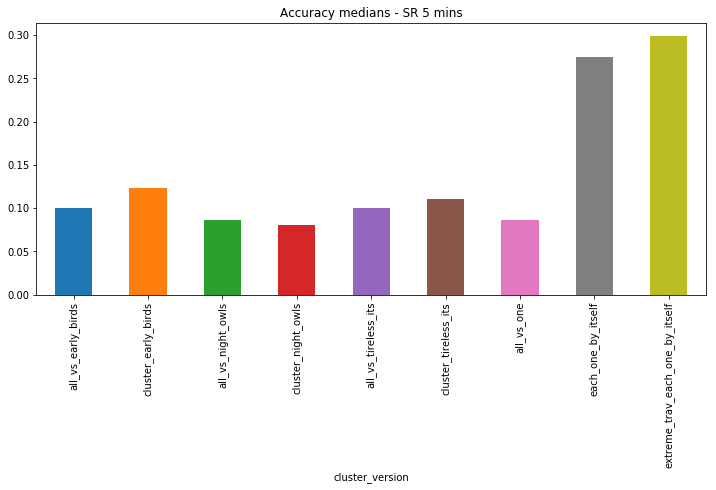

In [29]:
f, ax = plt.subplots(figsize=(12,5))
results_01_categ_05min.loc[order_i_05min]["acc"].plot.bar(title="Accuracy medians - SR 5 mins")

### Stop Region Stay Time: <font color="red">15 minutes</font>

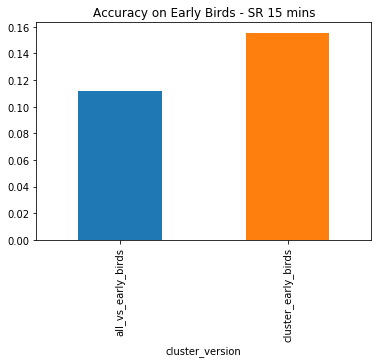

In [30]:
results_01_categ_15min.loc[order_i_15min[0:2]]["acc"].plot.bar(title="Accuracy on Early Birds - SR 15 mins")

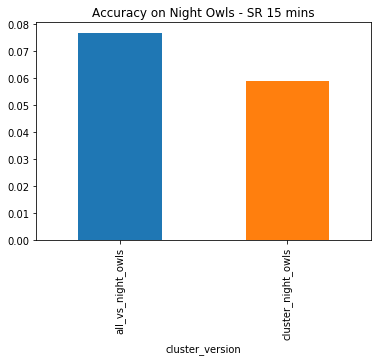

In [31]:
results_01_categ_15min.loc[order_i_15min[2:4]]["acc"].plot.bar(title="Accuracy on Night Owls - SR 15 mins")

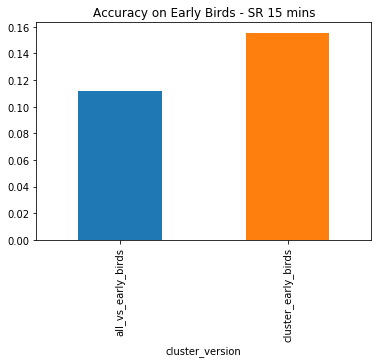

In [32]:
results_01_categ_15min.loc[order_i_15min[0:2]]["acc"].plot.bar(title="Accuracy on Early Birds - SR 15 mins")

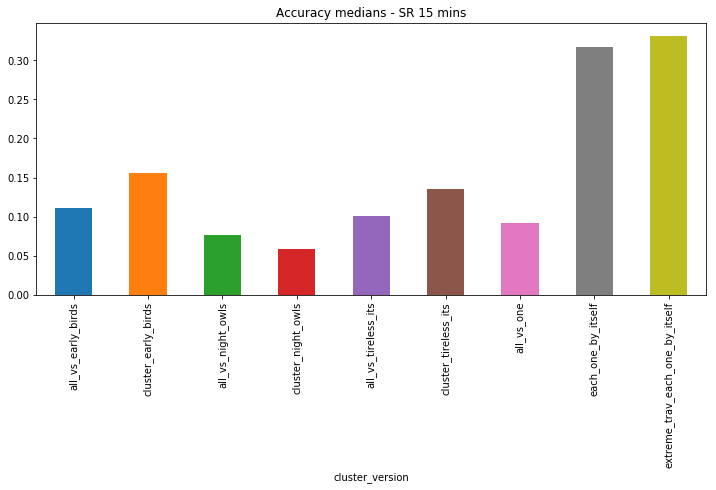

In [33]:
f, ax = plt.subplots(figsize=(12,5))
results_01_categ_15min.loc[order_i_15min]["acc"].plot.bar(title="Accuracy medians - SR 15 mins")

### Stop Region Stay Time: <font color="red">30 minutes</font>

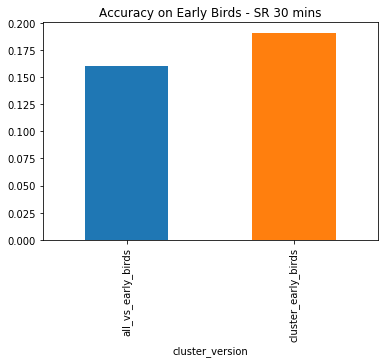

In [34]:
results_01_categ_30min.loc[order_i_30min[0:2]]["acc"].plot.bar(title="Accuracy on Early Birds - SR 30 mins")

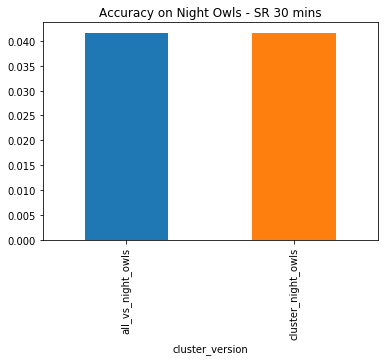

In [35]:
results_01_categ_30min.loc[order_i_30min[2:4]]["acc"].plot.bar(title="Accuracy on Night Owls - SR 30 mins")

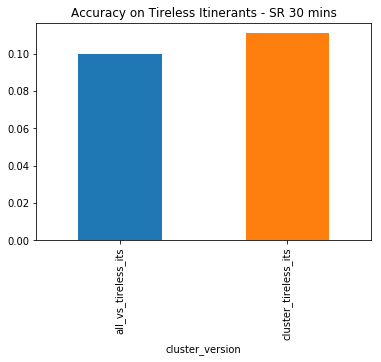

In [36]:
results_01_categ_05min.loc[order_i_05min[4:6]]["acc"].plot.bar(title="Accuracy on Tireless Itinerants - SR 30 mins")

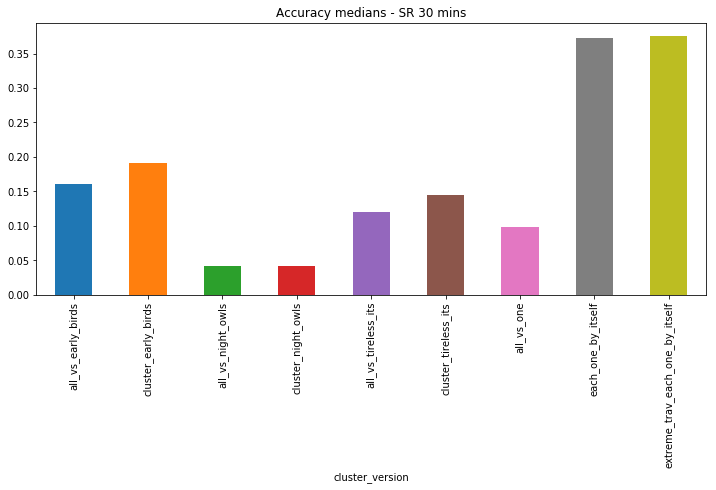

In [37]:
f, ax = plt.subplots(figsize=(12,5))
results_01_categ_30min.loc[order_i_30min]["acc"].plot.bar(title="Accuracy medians - SR 30 mins")